In [6]:
from aseMolec import pltProps as pp
from ase.io import read, write
import matplotlib.pyplot as plt
from aseMolec import extAtoms as ea 
import numpy as np
import glob
import re
import os


#read in data
path='./Paper'
test_path=f'{path}/eval/NaCl_test.xyz'
train_path=f'{path}/eval/NaCl_train.xyz'

eval_train=read(train_path, ':')
eval_test=read(test_path, ':')


### Learning Curve

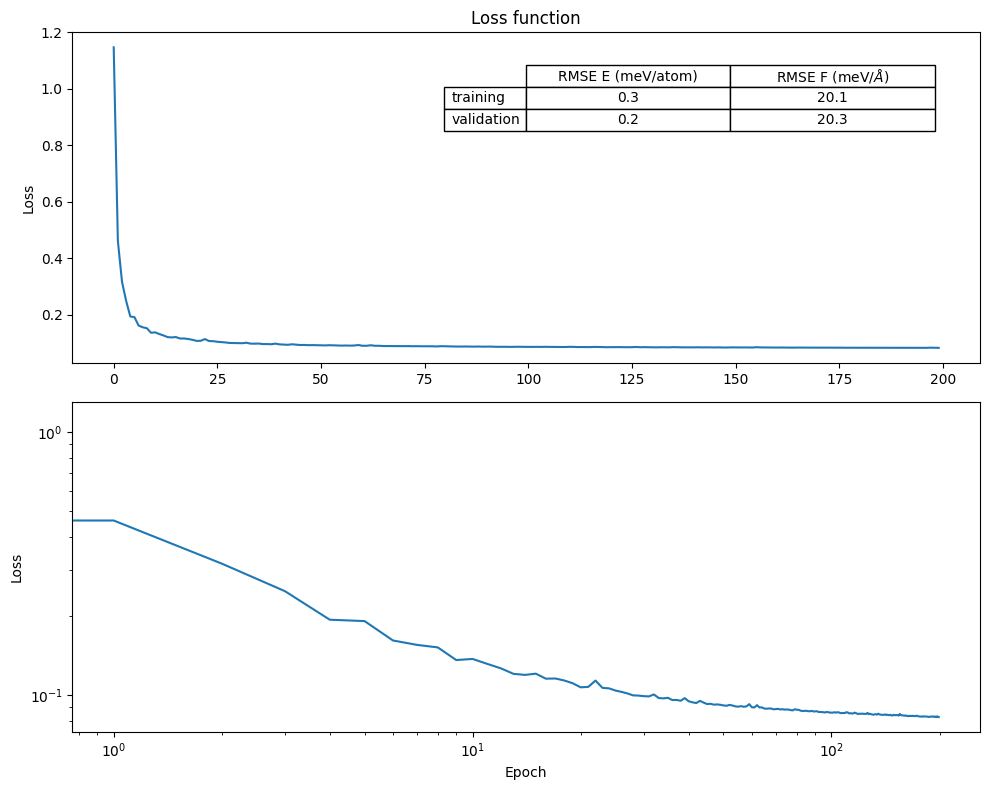

In [7]:
log_file=glob.glob(f'{path}/logs/*log')[0]


pattern = r"INFO:\sEpoch\s(?P<iter>\d+):\sloss=(?P<loss>\d+\.\d+),\sRMSE_E_per_atom=(?P<rmse_e>\d+\.\d+)\smeV,\sRMSE_F=(?P<rmse_f>\d+\.\d+)\smeV\s/\sA"
pattern_train = r"\|\s+train\s+\|\s+(?P<train_e>\d+\.\d+)\s+\|\s+(?P<train_f>\d+\.\d+)"
pattern_valid = r"\|\s+valid\s+\|\s+(?P<valid_e>\d+\.\d+)\s+\|\s+(?P<valid_f>\d+\.\d+)"

with open(log_file, 'r') as file:
    lines = file.readlines()

losses = []
rmse_es = []
rmse_fs = []
iters = []
train_e = train_f = valid_e = valid_f = None

for line in lines:
    match = re.search(pattern, line)
    if match:
        values = match.groupdict()
        rmse_es.append(float(values['rmse_e']))
        rmse_fs.append(float(values['rmse_f']))
        losses.append(float(values['loss']))
        iters.append(float(values['iter']))
    
    match_train = re.search(pattern_train, line)
    match_valid = re.search(pattern_valid, line)
    
    if match_train:
        train_e = match_train.group('train_e')
        train_f = match_train.group('train_f')
    if match_valid:
        valid_e = match_valid.group('valid_e')
        valid_f = match_valid.group('valid_f')

plt.figure(figsize=(10, 8))

# Upper plot with the table
plt.subplot(2, 1, 1)
plt.title('Loss function')
plt.plot(iters, losses)
plt.ylabel('Loss')

# Add table
if train_e and train_f and valid_e and valid_f:
    table_data = [
        [ "RMSE E (meV/atom)", r"RMSE F (meV/$\AA$)"],
        ["training", train_e, train_f],
        ["validation", valid_e, valid_f]
    ]

    col_labels = table_data[0]
    row_labels = [row[0] for row in table_data[1:]]
    cell_text = [row[1:] for row in table_data[1:]]

    table = plt.table(cellText=cell_text,
                      colLabels=col_labels,
                      rowLabels=row_labels,
                      cellLoc='center',
                      loc='upper right',
                      bbox=[0.5, 0.7, 0.45, 0.2])

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

# Lower plot
plt.subplot(2, 1, 2)
plt.yscale('log')
plt.xscale('log')
plt.plot(iters, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


### Training error

$$\operatorname{RMSD} = \sqrt{\frac{1}{n}\sum_{i=1}^n(X_i-x_0)^2}$$
The RRMSE is the relative root mean square error.

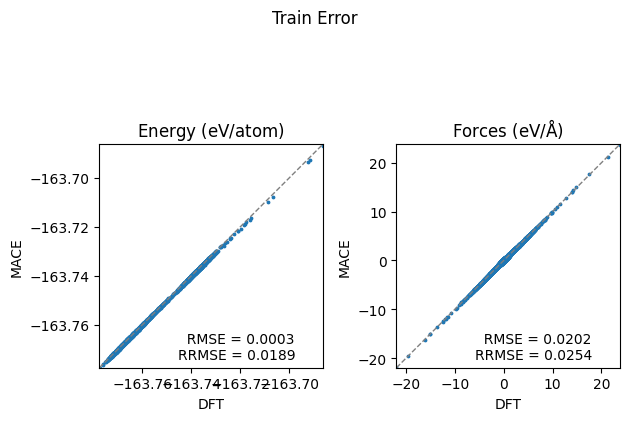

In [8]:
plt.subplot(1,2,1)
pp.plot_prop(ea.get_prop(eval_train, 'info', 'REF_energy', True).flatten(), \
                 ea.get_prop(eval_train, 'info', 'MACE_energy', True).flatten(), \
                 title=r'Energy $(\rm eV/atom)$ ', labs=['DFT','MACE'], rel=True)
plt.subplot(1,2,2)
pp.plot_prop(np.concatenate(ea.get_prop(eval_train, 'arrays', 'REF_forces')).flatten(), \
                 np.concatenate(ea.get_prop(eval_train, 'arrays', 'MACE_forces')).flatten(), \
                 title=r'Forces $\rm (eV/\AA)$ ', labs=['DFT','MACE'], rel=True)
plt.suptitle('Train Error')
plt.tight_layout()

### Test error

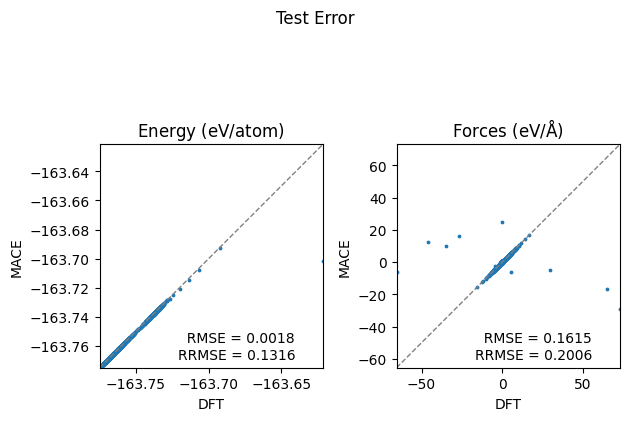

In [9]:
plt.subplot(1,2,1)
pp.plot_prop(ea.get_prop(eval_test, 'info', 'REF_energy', True).flatten(), \
                 ea.get_prop(eval_test, 'info', 'MACE_energy', True).flatten(), \
                 title=r'Energy $(\rm eV/atom)$ ', labs=['DFT','MACE'], rel=True)
plt.subplot(1,2,2)
pp.plot_prop(np.concatenate(ea.get_prop(eval_test, 'arrays', 'REF_forces')).flatten(), \
                 np.concatenate(ea.get_prop(eval_test, 'arrays', 'MACE_forces')).flatten(), \
                 title=r'Forces $\rm (eV/\AA)$ ', labs=['DFT','MACE'], rel=True)
plt.suptitle('Test Error')
plt.tight_layout()

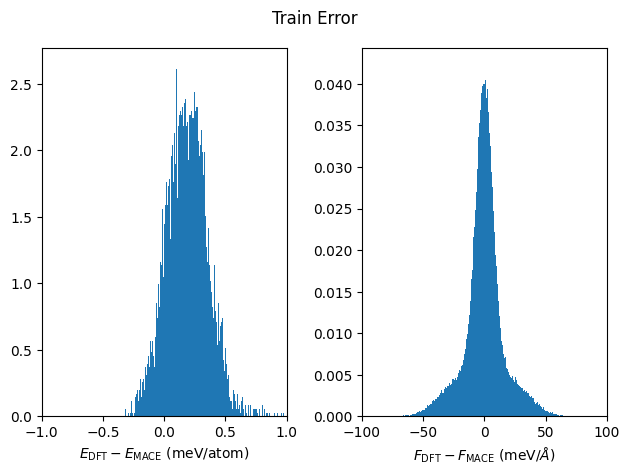

In [10]:
e_ref= ea.get_prop(eval_train, 'info', 'REF_energy', True)
e_mace= ea.get_prop(eval_train, 'info', 'MACE_energy', True)
f_ref= np.concatenate(ea.get_prop(eval_train, 'arrays', 'REF_forces')).flatten()
f_mace= np.concatenate(ea.get_prop(eval_train, 'arrays', 'MACE_forces')).flatten()

diff_e= (e_ref-e_mace)*1000
diff_f= (f_ref-f_mace)*1000

plt.subplot(1,2,1)
plt.hist(diff_e, 200, density=True)
plt.xlabel(r'$E_\text{DFT}-E_\text{MACE}$ (meV/atom)')
plt.xlim((-1, 1))
plt.subplot(1,2,2)

plt.subplot(1,2,2)
plt.hist(diff_f, 20000, density=True)
plt.xlabel(r'$F_\text{DFT}-F_\text{MACE}$ (meV/$\AA$)')
plt.xlim((-100, 100))

plt.suptitle('Train Error')
plt.tight_layout()

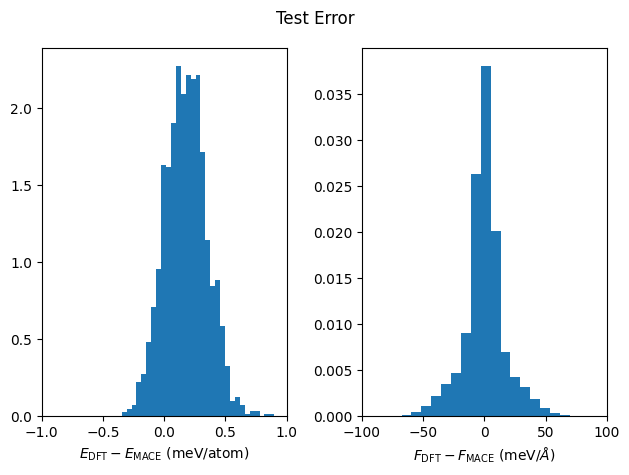

In [11]:
e_ref= ea.get_prop(eval_test, 'info', 'REF_energy', True)
e_mace= ea.get_prop(eval_test, 'info', 'MACE_energy', True)
f_ref= np.concatenate(ea.get_prop(eval_test, 'arrays', 'REF_forces')).flatten()
f_mace= np.concatenate(ea.get_prop(eval_test, 'arrays', 'MACE_forces')).flatten()

diff_e= (e_ref-e_mace)*1000
diff_f= (f_ref-f_mace)*1000

plt.subplot(1,2,1)
plt.hist(diff_e, 2000, density=True)
plt.xlabel(r'$E_\text{DFT}-E_\text{MACE}$ (meV/atom)')
plt.xlim((-1, 1))
plt.subplot(1,2,2)

plt.subplot(1,2,2)
plt.hist(diff_f, 20000, density=True)
plt.xlabel(r'$F_\text{DFT}-F_\text{MACE}$ (meV/$\AA$)')
plt.xlim((-100, 100))

plt.suptitle('Test Error')
plt.tight_layout()

## Elementwise Analysis

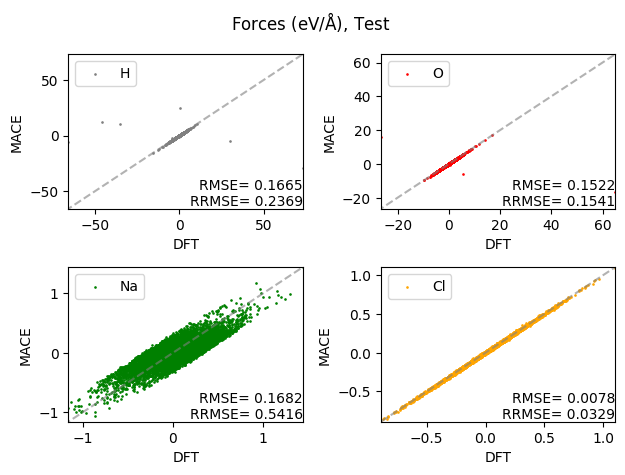

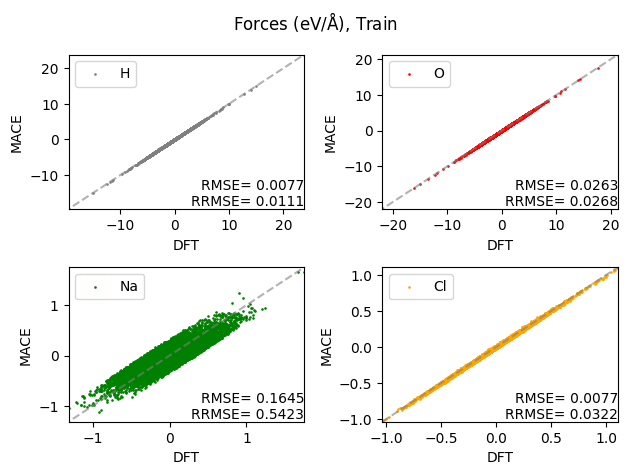

In [12]:


def get_forces(data):
    forces_ref=ea.get_prop(data, 'arrays', 'REF_forces')
    forces_mace=ea.get_prop(data, 'arrays', 'MACE_forces')
    elements=ea.get_prop(data, 'arrays', 'numbers')
    
    f_ref=[]
    f_mace=[]
    elem_dot_mag=[]
    for conf in range(len(elements)):
        single_config=[]
        for atom in range(len(elements[conf])):
            f_ref.append([elements[conf][atom], forces_ref[conf][atom]])
            f_mace.append([elements[conf][atom], forces_mace[conf][atom]])
            dot=np.dot(forces_ref[conf][atom], forces_mace[conf][atom])
            mag_ref=np.linalg.norm(forces_ref[conf][atom])
            mag_mace=np.linalg.norm(forces_mace[conf][atom])
            #single_config.append([elements[conf][atom], dot/(mag_ref*mag_mace), (mag_ref- mag_mace)/mag_ref])
            single_config.append([elements[conf][atom], dot/(mag_ref*mag_mace), (mag_ref- mag_mace)])
        elem_dot_mag.append(single_config)

    elem_dot_mag = np.array(elem_dot_mag).reshape(len(elements)*len(elements[0]),3)
    return f_ref, f_mace, elem_dot_mag


    
forces_ref, forces_mace, elem_dot_mag =get_forces(eval_test)
symbol={'H': 1.0, 'O': 8.0, 'Cl': 17.0, 'Na':11}
colors={'H': 'grey', 'O':'red', 'Cl': 'orange', 'Na': 'green'}

def plot_elem(element):
    
    f_ref=np.array([elem[1] for elem in forces_ref if elem[0]==symbol[element]]).flatten()
    f_mace=np.array([elem[1] for elem in forces_mace if elem[0]==symbol[element]]).flatten()
    rmse=np.sqrt(np.sum(1/len(f_ref)*(f_ref-f_mace)**2))
    rrmse=rmse/np.sqrt(np.sum(1/len(f_ref)*(f_ref)**2))
   
    plt.scatter(f_ref, f_mace, label=element, color=colors[element], s=0.8)
    plt.xlabel('DFT')
    plt.ylabel('MACE')
    plt.plot([-100,100], [-100,100], ls='dashed', alpha=0.6, color='grey')
    plt.legend()
    plt.xlim((min([min(f_mace), min(f_ref)]), max([max(f_ref),max(f_mace)])))
    plt.ylim((min([min(f_mace), min(f_ref)]), max([max(f_ref),max(f_mace)])))
    
    plt.text(max([max(f_ref),max(f_mace)]),min([min(f_mace), min(f_ref)]), f'RMSE= {rmse:.4f}\nRRMSE= {rrmse:.4f}',horizontalalignment='right',
        verticalalignment='bottom',
        fontsize=10, color='black')
    #plt.text(0, min(f_mace), f'RMSE= {rmse:.4f}\nRRMSE= {rrmse:.4f}')

fig = plt.figure()
plt.subplot(2,2,1)  
plot_elem('H')
plt.subplot(2,2,2)  
plot_elem('O')
plt.subplot(2,2,3)  
plot_elem('Na')
plt.subplot(2,2,4)  
plot_elem('Cl')
fig.suptitle(r'Forces $\rm (eV/\AA)$, Test ')
plt.tight_layout()

forces_ref, forces_mace, elem_dot_mag =get_forces(eval_train)
fig = plt.figure()
plt.subplot(2,2,1)  
plot_elem('H')
plt.subplot(2,2,2)  
plot_elem('O')
plt.subplot(2,2,3)  
plot_elem('Na')
plt.subplot(2,2,4)  
plot_elem('Cl')
fig.suptitle(r'Forces $\rm (eV/\AA)$, Train')
plt.tight_layout()

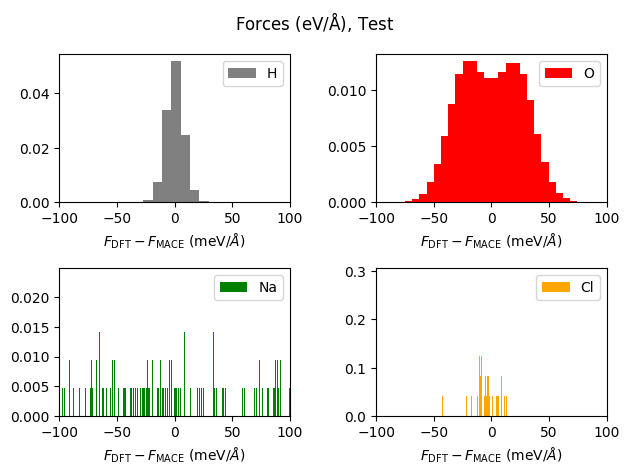

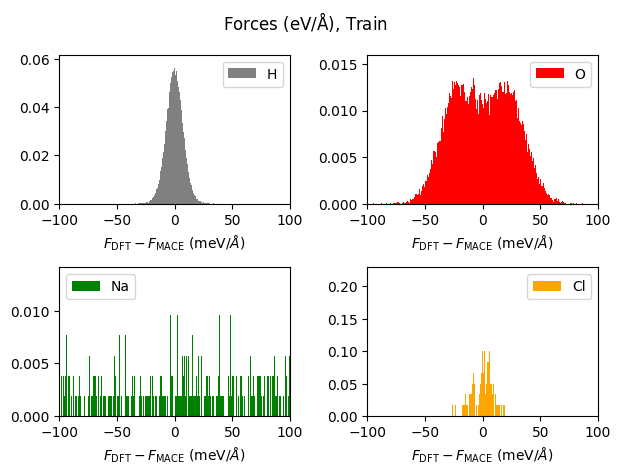

In [13]:
def plot_hist(element):
    
    f_ref=np.array([elem[1] for elem in forces_ref if elem[0]==symbol[element]]).flatten()
    f_mace=np.array([elem[1] for elem in forces_mace if elem[0]==symbol[element]]).flatten()
    diff=(f_ref-f_mace)*1000
    plt.xlim((-100, 100))
    plt.hist(diff, 20000, density=True, label=element, color=colors[element])
    plt.xlabel(r'$F_\text{DFT}-F_\text{MACE}$ (meV/$\AA$)')
    plt.legend()
    
forces_ref, forces_mace, elem_dot_mag =get_forces(eval_test)
fig = plt.figure()
plt.subplot(2,2,1)  
plot_hist('H')

plt.subplot(2,2,2)  
plot_hist('O')

plt.subplot(2,2,3)  
plot_hist('Na')

plt.subplot(2,2,4)  
plot_hist('Cl')

fig.suptitle(r'Forces $\rm (eV/\AA)$, Test ')

plt.tight_layout()

forces_ref, forces_mace, elem_dot_mag =get_forces(eval_train)
fig = plt.figure()
plt.subplot(2,2,1)  
plot_hist('H')

plt.subplot(2,2,2)  
plot_hist('O')

plt.subplot(2,2,3)  
plot_hist('Na')

plt.subplot(2,2,4)  
plot_hist('Cl')

fig.suptitle(r'Forces $\rm (eV/\AA)$, Train ')

plt.tight_layout()


Text(0.5, 0.98, 'Train')

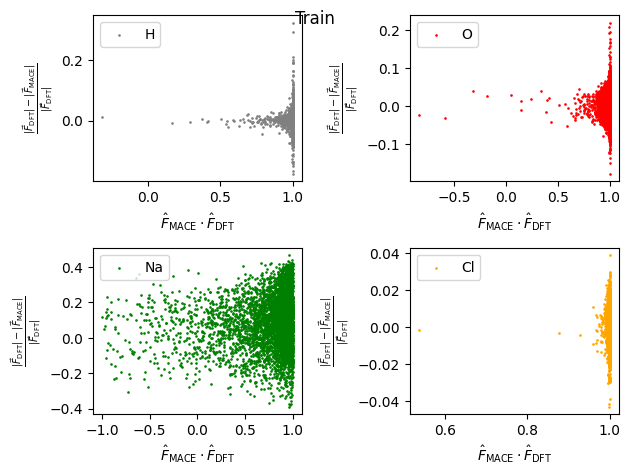

In [14]:
#forces_ref, forces_mace, elem_dot_mag =get_forces(eval_test)
symbol={'H': 1.0, 'O': 8.0, 'Cl': 17.0, 'Na':11}
colors={'H': 'grey', 'O':'red', 'Cl': 'orange', 'Na': 'green'}

def plot_dot_prod(element):
    f_dot=np.array([elem[1] for elem in elem_dot_mag if elem[0]==symbol[element]]).flatten()
    f_mag=np.array([elem[2] for elem in elem_dot_mag if elem[0]==symbol[element]]).flatten()
   
    plt.scatter(f_dot, f_mag, label=element, color=colors[element], s=0.8)
    plt.xlabel(r'$\hat{F}_\text{MACE}\cdot\hat{F}_\text{DFT}$')
    plt.ylabel(r'|\vec{F}_\text{MACE}|')
    plt.ylabel(r'$\frac{|\vec{F}_\text{DFT}|-|\vec{F}_\text{MACE}|}{|\vec{F}_\text{DFT}|}$')
    plt.legend()

fig = plt.figure()

plt.subplot(2,2,1)  
plot_dot_prod('H')

plt.subplot(2,2,2)  
plot_dot_prod('O')

plt.subplot(2,2,3)  
plot_dot_prod('Na')

plt.subplot(2,2,4)  
plot_dot_prod('Cl')

plt.tight_layout()
fig.suptitle(r'Train')

## Outliers
Use [Chauvenet's criterion](https://en.wikipedia.org/wiki/Chauvenet%27s_criterion).
$$D_{\mathrm{max}} \ge \frac{|x - \bar x|}{s_x}$$

where
* $D_{\mathrm{max}}$ is the maximum allowable deviation,
* $| \cdot |$ is the absolute value,
* $x$ is the value of suspected outlier,
* $\bar x$ is sample mean, and
* $s_x$ is sample standard deviation


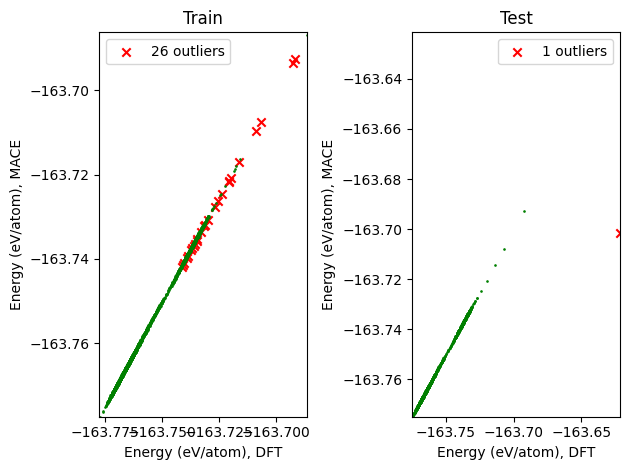

In [15]:

from scipy import special
e_ref_train= ea.get_prop(eval_train, 'info', 'REF_energy', True)
e_mace_train= ea.get_prop(eval_train, 'info', 'MACE_energy', True)
e_ref_test= ea.get_prop(eval_test, 'info', 'REF_energy', True)
e_mace_test= ea.get_prop(eval_test, 'info', 'MACE_energy', True)


def filter_energies_chevron(e_ref, e_mace):
    diff=e_ref-e_mace
    mean=np.mean(diff)
    std=np.std(diff)
    criterion=1/(64*len(diff))
    deviation= np.abs(diff - mean)/std
    probabilities = special.erfc(deviation)
    mask=probabilities < criterion
    indices = [index for index, value in enumerate(mask) if value==True]
    indices_opp = [index for index, value in enumerate(mask) if value==False]
    outliers_mace = e_mace[indices]
    inliers_mace=e_mace[indices_opp]
    
    outliers_ref = e_ref[indices]
    inliers_ref=e_ref[indices_opp]
    plt.scatter(outliers_ref, outliers_mace, label=f'{len(indices)} outliers',marker="x", color='red')
    plt.scatter(inliers_ref, inliers_mace,  color='green', s=0.8)
    plt.xlabel('Energy (eV/atom), DFT')
    plt.ylabel('Energy (eV/atom), MACE')
    plt.plot([-100,100], [-100,100], ls='dashed', alpha=0.6, color='grey')
    plt.legend()
    plt.xlim((min([min(e_mace), min(e_ref)]), max([max(e_ref),max(e_mace)])))
    plt.ylim((min([min(e_mace), min(e_ref)]), max([max(e_ref),max(e_mace)])))
    plt.plot([-100,100], [-100,100], ls='dashed', alpha=0.6, color='grey')
    
    return  indices

plt.subplot(1,2,2)
plt.title('Test')
indices= filter_energies_chevron(e_ref_test, e_mace_test)


plt.subplot(1,2,1)
plt.title('Train')
filter_energies_chevron(e_ref_train, e_mace_train)

plt.tight_layout()


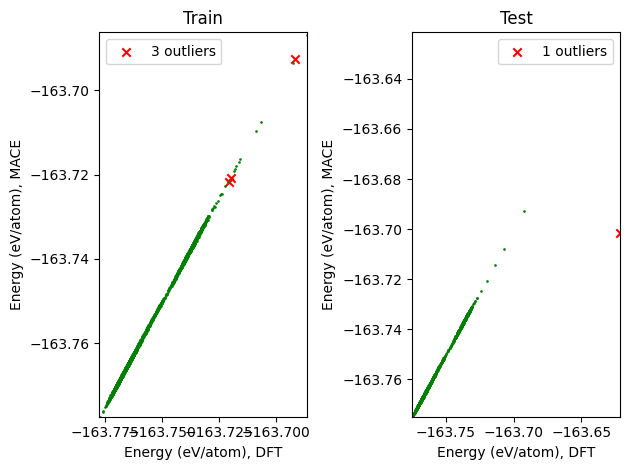

In [16]:
import math

e_ref_train= ea.get_prop(eval_train, 'info', 'REF_energy', True)
e_mace_train= ea.get_prop(eval_train, 'info', 'MACE_energy', True)
e_ref_test= ea.get_prop(eval_test, 'info', 'REF_energy', True)
e_mace_test= ea.get_prop(eval_test, 'info', 'MACE_energy', True)


def filter_energies_rmse(e_ref, e_mace):
    
    MSE = np.square(np.subtract(e_ref,e_mace)).mean() 
 
    RMSE = math.sqrt(MSE)
    diff=e_ref-e_mace
    
    indices = [index for index, value in enumerate(diff) if np.abs(value)> 4*RMSE]
    indices_opp = [index for index, value in enumerate(diff) if np.abs(value)<= 4*RMSE]
    outliers_mace = e_mace[indices]
    inliers_mace=e_mace[indices_opp]
    
    outliers_ref = e_ref[indices]
    inliers_ref=e_ref[indices_opp]
    plt.scatter(outliers_ref, outliers_mace, label=f'{len(indices)} outliers',marker="x", color='red')
    plt.scatter(inliers_ref, inliers_mace,  color='green', s=0.8)
    plt.xlabel('Energy (eV/atom), DFT')
    plt.ylabel('Energy (eV/atom), MACE')
    plt.plot([-100,100], [-100,100], ls='dashed', alpha=0.6, color='grey')
    plt.legend()
    plt.xlim((min([min(e_mace), min(e_ref)]), max([max(e_ref),max(e_mace)])))
    plt.ylim((min([min(e_mace), min(e_ref)]), max([max(e_ref),max(e_mace)])))
    plt.plot([-100,100], [-100,100], ls='dashed', alpha=0.6, color='grey')
    
    return  indices

plt.subplot(1,2,2)
plt.title('Test')
indices_test= filter_energies_rmse(e_ref_test, e_mace_test)

output_dir=f'{path}/outliers_energy'
os.makedirs(output_dir, exist_ok=True)
write(f'{output_dir}/outliers_test.xyz',  [eval_test[i] for i in indices_test])

plt.subplot(1,2,1)
plt.title('Train')
indices_train=filter_energies_rmse(e_ref_train, e_mace_train)
write(f'{output_dir}/outliers_train.xyz', [eval_train[i] for i in indices_train])

plt.tight_layout()


The 0th coordinate of H no 118 in frame 1351 is an outlier
The 1th coordinate of H no 118 in frame 1351 is an outlier
The 2th coordinate of H no 118 in frame 1351 is an outlier
The 0th coordinate of H no 119 in frame 1351 is an outlier
The 1th coordinate of H no 119 in frame 1351 is an outlier
The 2th coordinate of H no 119 in frame 1351 is an outlier
The 0th coordinate of O no 59 in frame 1351 is an outlier
The 1th coordinate of O no 59 in frame 1351 is an outlier
The 2th coordinate of O no 59 in frame 1351 is an outlier
The 0th coordinate of H no 3 in frame 58 is an outlier
The 1th coordinate of H no 3 in frame 58 is an outlier
The 2th coordinate of H no 3 in frame 58 is an outlier
The 2th coordinate of H no 89 in frame 874 is an outlier
The 1th coordinate of H no 118 in frame 1734 is an outlier
The 1th coordinate of H no 6 in frame 2818 is an outlier
The 1th coordinate of H no 7 in frame 2818 is an outlier
The 0th coordinate of H no 30 in frame 2818 is an outlier
The 1th coordinate 

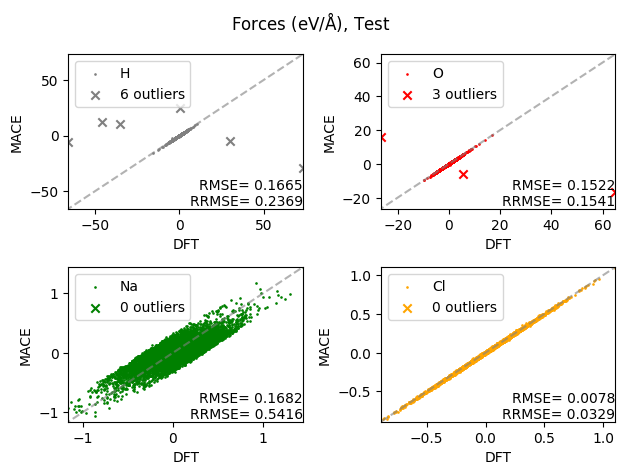

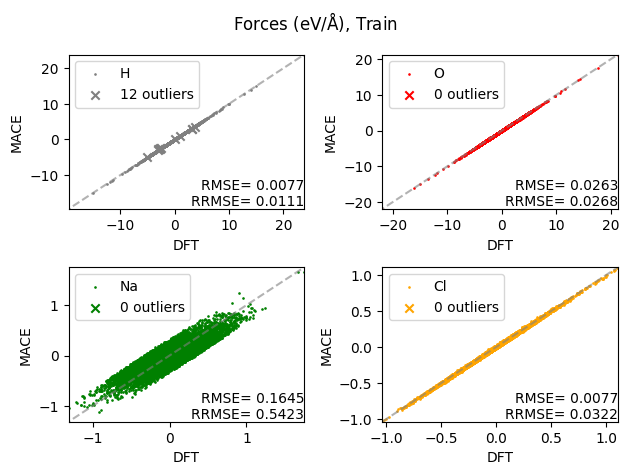

In [17]:
number={1.0: 'H', 8.0: 'O', 17.0: 'Cl', 11.0:'Na'}

def filter_forces(element, data,output_dir='outliers_forces', output_name='outliers_'):
    elements=ea.get_prop(data, 'arrays', 'numbers')
    os.makedirs(output_dir, exist_ok=True)
    
    
    #compute rmse
    forces_ref, forces_mace, _ = get_forces(data) 
    f_ref=np.array([elem[1] for elem in forces_ref if elem[0]==symbol[element]]).flatten()
    f_mace=np.array([elem[1] for elem in forces_mace if elem[0]==symbol[element]]).flatten()
    diff=f_ref-f_mace
    rmse=np.sqrt(np.sum(1/len(f_ref)*(f_ref-f_mace)**2))
    rrmse=rmse/np.sqrt(np.sum(1/len(f_ref)*(f_ref)**2))
    
    indices = [index for index, value in enumerate(diff) if np.abs(value)> 20*rmse]
    indices_opp = [index for index, value in enumerate(diff) if np.abs(value)<= 20*rmse]
    
    outliers_mace = f_mace[indices]
    inliers_mace=f_mace[indices_opp]
    outliers_ref = f_ref[indices]
    inliers_ref=f_ref[indices_opp]
    
    #get indices of frames
    n_atoms=np.count_nonzero(elements[0] == symbol[element])
    
    
    indices_frames = []
    for index in indices:
        frame=int(index/(n_atoms*3))
        atom=int((index%frame)/3)
        coord=(index%(194*3))%3
        indices_frames.append(frame)
        print(f'The {coord}th coordinate of {element} no {atom} in frame {frame} is an outlier')

    output_name+=f'_{element}.xyz'
    if len(indices_frames) >0:
        write(f'{output_dir}/{output_name}',  [data[i] for i in indices_frames])
    
    
    
    
    return outliers_mace, inliers_mace, outliers_ref, inliers_ref, rmse, rrmse, indices_frames
    
    


def plot_elem_outliers(element, data, output_dir='outliers_forces', output_name='outliers_'):
    
    outliers_mace, inliers_mace, outliers_ref, inliers_ref, rmse, rrmse, _ = filter_forces(element, data, output_dir=output_dir, output_name=output_name)
    forces_ref, forces_mace, _ =get_forces(data) 
    f_ref=np.array([elem[1] for elem in forces_ref if elem[0]==symbol[element]]).flatten()
    f_mace=np.array([elem[1] for elem in forces_mace if elem[0]==symbol[element]]).flatten()
    plt.scatter(inliers_ref, inliers_mace, label=element, color=colors[element], s=0.8)
    plt.scatter(outliers_ref, outliers_mace, label=f'{len(outliers_mace)} outliers', color=colors[element], marker="x" )
    plt.xlabel('DFT')
    plt.ylabel('MACE')
    plt.plot([-100,100], [-100,100], ls='dashed', alpha=0.6, color='grey')
    plt.legend()
    plt.xlim((min([min(f_mace), min(f_ref)]), max([max(f_ref),max(f_mace)])))
    plt.ylim((min([min(f_mace), min(f_ref)]), max([max(f_ref),max(f_mace)])))
    
    plt.text(max([max(f_ref),max(f_mace)]),min([min(f_mace), min(f_ref)]), f'RMSE= {rmse:.4f}\nRRMSE= {rrmse:.4f}',horizontalalignment='right',
        verticalalignment='bottom',
        fontsize=10, color='black')
    
    return indices



fig = plt.figure()
plt.subplot(2,2,1)  
plot_elem_outliers('H', eval_test, output_name='outliers_test')
plt.subplot(2,2,2)  
plot_elem_outliers('O',eval_test, output_name='outliers_test')
plt.subplot(2,2,3)  
plot_elem_outliers('Na', eval_test, output_name='outliers_test')
plt.subplot(2,2,4)  
plot_elem_outliers('Cl', eval_test, output_name='outliers_test')
fig.suptitle(r'Forces $\rm (eV/\AA)$, Test ')
plt.tight_layout()


fig = plt.figure()
plt.subplot(2,2,1)  
plot_elem_outliers('H', eval_train, output_name='outliers_train')
plt.subplot(2,2,2)  
plot_elem_outliers('O', eval_train, output_name='outliers_train')
plt.subplot(2,2,3)  
plot_elem_outliers('Na', eval_train, output_name='outliers_train')
plt.subplot(2,2,4)  
plot_elem_outliers('Cl', eval_train, output_name='outliers_train')
fig.suptitle(r'Forces $\rm (eV/\AA)$, Train')
plt.tight_layout()